# Critical Path Method

This notebook demonstrates the Critical Path Method.

## Background

The Critical Path Method is a technique for calculating the shortest time span needed to complete a series of tasks. The tasks are represented by nodes, each labelled with the duration. The precedence order of the task is given by a set of arcs.

Here we demonstrate the representation and calculation of the critical path. Decision variables are introduced for

* Earliest Start
* Earliest Finish
* Latest Start
* Latest Finish
* Slack = Earliest Finish - Earliest Start = Latest Finish - Earliest Finish

Tasks on the Critical Path have zero slack.

## Example: Stadium Construction

Stadium Construction, [Example 7.1.1](http://www.maximalsoftware.com/modellib/modXpressMP.html) from [Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 7, Dash Optimization, 2000](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.69.9634&rep=rep1&type=pdf).

In [13]:
tasks = {
    "T01": {"dur":  2.0, "desc": "Installing the contruction site"},
    "T02": {"dur": 16.0, "desc": "Terracing"},
    "T03": {"dur":  9.0, "desc": "Constructing the foundations"},
    "T04": {"dur":  8.0, "desc": "Access roads and other networks"},
    "T05": {"dur": 10.0, "desc": "Erecting the basement"},
    "T06": {"dur":  6.0, "desc": "Main floor"},
    "T07": {"dur":  2.0, "desc": "Dividing up the changing rooms"},
    "T08": {"dur":  2.0, "desc": "Electrifying the terraces"},
    "T09": {"dur":  9.0, "desc": "Constructing the roof"},
    "T10": {"dur":  5.0, "desc": "Lighting the stadium"},
    "T11": {"dur":  3.0, "desc": "Installing the terraces"},
    "T12": {"dur":  2.0, "desc": "Sealing the roof"},
    "T13": {"dur":  1.0, "desc": "Finishing the changing rooms"},
    "T14": {"dur":  7.0, "desc": "Constructing the ticket office"},
    "T15": {"dur":  4.0, "desc": "Secondary access roads"},
    "T16": {"dur":  3.0, "desc": "Means of signaling"},
    "T17": {"dur":  9.0, "desc": "Lawn and sports accessories"},
    "T18": {"dur":  1.0, "desc": "Handing over the building"}
}

pred = [
    ("T01", "T02"),
    ("T02", "T03"),
    ("T02", "T04"),
    ("T02", "T14"),
    ("T03", "T05"),
    ("T04", "T07"),
    ("T04", "T10"),
    ("T04", "T09"),
    ("T04", "T06"),
    ("T04", "T15"),
    ("T05", "T06"),
    ("T06", "T09"),
    ("T06", "T11"),
    ("T06", "T08"),
    ("T07", "T13"),
    ("T08", "T16"),
    ("T09", "T12"),
    ("T11", "T16"),
    ("T12", "T17"),
    ("T14", "T16"),
    ("T14", "T15"),
    ("T17", "T18")
]

In [59]:
import pyomo.environ as pyo

m = pyo.ConcreteModel("Stadium Construction")

m.TASKS = pyo.Set(initialize=tasks.keys())
m.ARCS = pyo.Set(initialize=pred)

m.earliest_start = pyo.Var(m.TASKS, domain=pyo.NonNegativeReals)
m.earliest_finish = pyo.Var(m.TASKS, domain=pyo.NonNegativeReals)
m.latest_start = pyo.Var(m.TASKS, domain=pyo.NonNegativeReals)
m.latest_finish = pyo.Var(m.TASKS, domain=pyo.NonNegativeReals)
m.slack = pyo.Var(m.TASKS, domain=pyo.NonNegativeReals)

m.finish_time = pyo.Var(domain=pyo.NonNegativeReals)

@m.Objective(sense=pyo.minimize)
def minimize_finish_time(m):
    return 100*m.finish_time - sum(m.slack[task] for task in m.TASKS)

@m.Constraint(m.TASKS)
def early(m, task):
    return m.earliest_finish[task] <= m.finish_time

@m.Constraint(m.TASKS)
def late(m, task):
    return m.latest_finish[task] <= m.finish_time

@m.Constraint(m.TASKS)
def dur_early(m, task):
    return m.earliest_finish[task] == m.earliest_start[task] + tasks[task]["dur"]

@m.Constraint(m.TASKS)
def dur_late(m, task):
    return m.latest_finish[task] == m.latest_start[task] + tasks[task]["dur"]

@m.Constraint(m.TASKS)
def slack_def(m, task):
    return m.slack[task] == m.latest_start[task] - m.earliest_start[task]

@m.Constraint(m.ARCS)
def arc_early(m, a, b):
    return m.earliest_finish[a] <= m.earliest_start[b]

@m.Constraint(m.ARCS)
def arc_late(m, a, b):
    return m.latest_finish[a] <= m.latest_start[b]

solver = pyo.SolverFactory("cbc")
solver.solve(m);

In [62]:
import pandas as pd

df = pd.DataFrame(tasks).T

for task in m.TASKS:
    df.loc[task, "earliest start"] = m.earliest_start[task]()
    df.loc[task, "earliest finish"] = m.earliest_finish[task]()
    df.loc[task, "latest start"] = m.latest_start[task]()
    df.loc[task, "latest finish"] = m.latest_finish[task]()    
    
df["slack"] = df["latest start"] - df["earliest start"]

display(df[df["slack"] <= 0.1])

display(df[df["slack"] > 0.1])

,dur,desc,earliest start,earliest finish,latest start,latest finish,slack
T01,2.0,Installing the contruction site,0.0,2.0,0.0,2.0,0.0
T02,16.0,Terracing,2.0,18.0,2.0,18.0,0.0
T03,9.0,Constructing the foundations,18.0,27.0,18.0,27.0,0.0
T05,10.0,Erecting the basement,27.0,37.0,27.0,37.0,0.0
T06,6.0,Main floor,37.0,43.0,37.0,43.0,0.0
T09,9.0,Constructing the roof,43.0,52.0,43.0,52.0,0.0
T12,2.0,Sealing the roof,52.0,54.0,52.0,54.0,0.0
T17,9.0,Lawn and sports accessories,54.0,63.0,54.0,63.0,0.0
T18,1.0,Handing over the building,63.0,64.0,63.0,64.0,0.0


,dur,desc,earliest start,earliest finish,latest start,latest finish,slack
T04,8.0,Access roads and other networks,18.0,26.0,29.0,37.0,11.0
T07,2.0,Dividing up the changing rooms,26.0,28.0,61.0,63.0,35.0
T08,2.0,Electrifying the terraces,43.0,45.0,59.0,61.0,16.0
T10,5.0,Lighting the stadium,26.0,31.0,59.0,64.0,33.0
T11,3.0,Installing the terraces,43.0,46.0,58.0,61.0,15.0
T13,1.0,Finishing the changing rooms,28.0,29.0,63.0,64.0,35.0
T14,7.0,Constructing the ticket office,18.0,25.0,53.0,60.0,35.0
T15,4.0,Secondary access roads,26.0,30.0,60.0,64.0,34.0
T16,3.0,Means of signaling,46.0,49.0,61.0,64.0,15.0


## Visualization

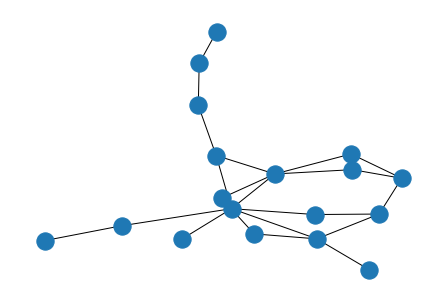

In [64]:
import networkx as nx

G = nx.Graph()

for a, b in m.ARCS:
    G.add_edge(a, b)

nx.draw(G)
